In [2]:
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
import PIL as PIL
import time

from skimage import measure
from mpl_toolkits.mplot3d import Axes3D 
from PIL import Image

np.set_printoptions(threshold = 1000)

Implement a function surface_transform, which takes two input arguments 

1) a triangulated surface, 
represented by a list of vertices and a list of triangles, and
2)  a vector of rigid transformation 
parameters, representing a rigid spatial transformaton

This function should return  triangulated 
surface that is transformed by the specified spatial transformation. In the function, comments shoud 
be included to explain the definition of the adopted coordinate system.

In [4]:
# Load the segmentation file “label_train00.npy” file. 

label_train = np.load(r"label_train00.npy")

# This loads a 128 x 128 x 32 3d dataset. 

# The npy file stores data in binary format, so I have set the marching cubes "threshold" value to 0.5 - this will 
# contour all voxels represented by a value of 1

# Use sckit-image.measure.marching_cubes algorithm to compute vertex coordinates in mm and triangles for
# representing the segmentation boundary.

# Voxel dimensions are 0.5 mm x 0.5 mm x 2.0 mm 
# I have chosen to use a cartesian co-ordinate system, with the image positioned relative to the origin at
# (0, 0, 0) in the left bottom corner. Axis dimensions are displayed in mm. 

verts, faces, normals, values = measure.marching_cubes(label_train, 0.5, spacing = (2.0, 0.5, 0.5), step_size = 1)
print("Vertex co-ordinates (mm) are:  \n" + str(verts) + "\n")
print("Triangle indices are:  \n" + str(faces)+ "\n")

Vertex co-ordinates (mm) are:  
[[15.   20.   29.5 ]
 [16.   20.   29.25]
 [16.   19.75 29.5 ]
 ...
 [49.   25.   31.  ]
 [49.   25.   31.5 ]
 [49.   25.   32.  ]]

Triangle indices are:  
[[   2    1    0]
 [   4    3    0]
 [   0    3    2]
 ...
 [6493 6624 6495]
 [6495 6624 6625]
 [6495 6625 6470]]



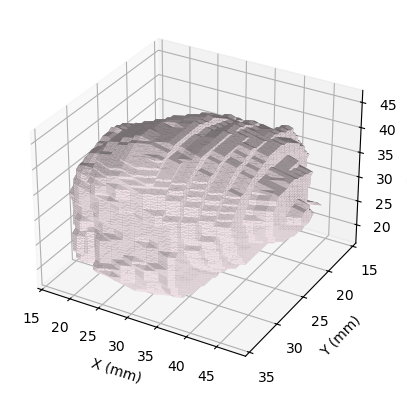

In [5]:
# Display resulting triangular mesh using Matplotlib. 

vertices = np.array(verts)
indices = np.array(faces)

x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(np.min(vertices[:,0]), np.max(vertices[:,0]))
ax.set_ylim(np.min(vertices[:,1]), np.max(vertices[:,1])) 
ax.invert_yaxis()     # y-axis inverted so that image is relative to the origin at (0, 0, 0)
ax.set_zlim(np.min(vertices[:,2]), np.max(vertices[:,2]))

ax.plot_trisurf(x, y, z, triangles=indices, color = "lavenderblush") 

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

plt.show()

Implement a function surface_transform, which takes two input arguments 1) a triangulated surface, represented
by a list of vertices and a list of triangles, and 2) a vector of rigid transformation parameters.

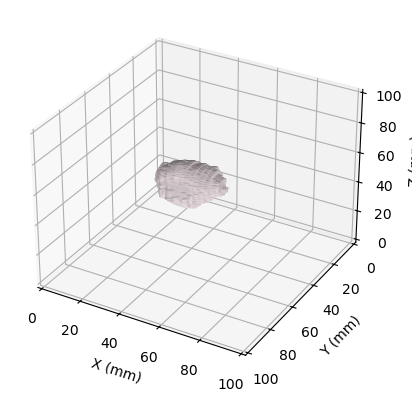

In [6]:
# The "surface_transform" function firstly creates a "ones" matrix, which appends the image 
#co-ordinate matrix with a column of ones to transform the image co-ordinates in 3D relative to 
# the origin.

# The function then multiplies the "ones" matrix by a 4 x 4 transformation matrix incorporaring 
# rotation, R, and translation, t, i.e. new point P_new = R @ P0 + t

# Finally, the function removes the "ones" column to return the  matrix co-ordinates of the 
# transformed image.

def surface_transform(image, transform):
    ones = np.reshape(np.ones(len(image)),(len(image), 1))   
    image_ones = np.transpose(np.append(image, ones, axis = 1))
    image_transform = transform @ image_ones
    transform_transpose = np.transpose(image_transform)
    new_image = np.delete(transform_transpose, 3, axis = 1)
    return(new_image)

# Copy vertex coordinates using the new function, transforming the original surface by the identity matrix. 
# I0 will represent the co-ordinates of the copied surface.

T_I = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
               [0, 0, 0, 1]])

I0 = surface_transform(vertices, T_I)
I0_triangles = surface_transform(indices, T_I)
   
x_I0 = I0[:, 0]
y_I0 = I0[:, 1]
z_I0 = I0[:, 2]

fig_I0 = plt.figure()
ax_I0 = fig_I0.add_subplot(111, projection='3d')

ax_I0.set_xlim(0, 100)
ax_I0.set_ylim(0, 100) 
ax_I0.invert_yaxis()  
ax_I0.set_zlim(0, 100)

ax_I0.plot_trisurf(x_I0, y_I0, z_I0, triangles = I0_triangles, color = "lavenderblush") 

ax_I0.set_xlabel("X (mm)")
ax_I0.set_ylabel("Y (mm)")
ax_I0.set_zlabel("Z (mm)")

plt.savefig("original_surface.png", format = "png")  # Save plot as .png file
plt.show()

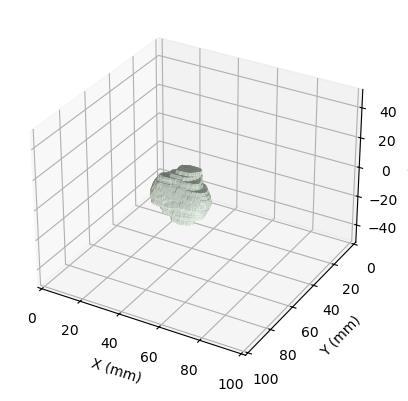

In [7]:
# Surface transform 1. 
# Combine rotation of 60 degrees around the x-axis, 
                    # 90 degrees around the y- axis and 
                    # -45 degrees around the z-axis 
# with a translation of 50 mm in the x-direction, 
                      # 25 mm in the y-direction and 
                      #-125 mm in the z-direction

# Trigonometric functions in numpy require angles given in radians

theta_x = np.pi/3
theta_y = np.pi/2
theta_z = -(np.pi/4)

# Rotation around the x-axis
Rot_X1 = np.array([[1, 0, 0, 0],
                  [0, np.cos(theta_x), -np.sin(theta_x), 0],
                  [0, np.sin(theta_x), np.cos(theta_x), 0],
                  [0, 0, 0, 1]])

# Rotation around the y-axis
Rot_Y1 = np.array([[np.cos(theta_y), 0, np.sin(theta_y), 0],
                  [0, 1 , 0, 0],
                  [-np.sin(theta_y), 0, np.cos(theta_y), 0],
                  [0, 0, 0, 1]])

Rot_Z1 = np.array([[np.cos(theta_z), -np.sin(theta_z), 0, 0],
                  [np.sin(theta_z), np.cos(theta_z) , 0, 0],
                  [0, 0 , 1, 0],
                  [0, 0, 0, 1]])


Translate_1 = np.transpose(np.array([[1, 0, 0, 50],
                        [0, 1, 0, 25],
                        [0, 0, 1, -125],
                        [0, 0, 0, 1]]))

transform_1 = Rot_X1 @ Rot_Y1 @ Rot_Z1 @ Translate_1

I1 = surface_transform(I0, transform_1)

x_I1 = I1[:, 0]
y_I1 = I1[:, 1]
z_I1 = I1[:, 2]

fig_I1 = plt.figure()
ax_I1 = fig_I1.add_subplot(111, projection='3d')

ax_I1.set_xlim(0, 100)
ax_I1.set_ylim(0, 100)
ax_I1.invert_yaxis()  
ax_I1.set_zlim(-50, 50)

ax_I1.set_xlabel("X (mm)")
ax_I1.set_ylabel("Y (mm)")
ax_I1.set_zlabel("Z (mm)")

# Plot transformed surface, I1:
ax_I1.plot_trisurf(x_I1, y_I1, z_I1, triangles = indices, color = "honeydew")
plt.savefig("transformed_surface_1.png", format = "png")
plt.show()

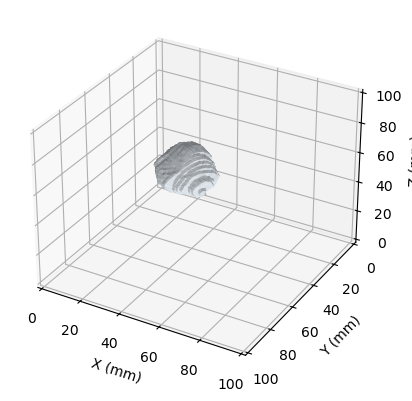

In [8]:
# Surface transform 2. 
# Combine rotation of 30 degrees around the x-axis, 
                    # 30 degrees around the y- axis and 
                    # 30 degrees around the z-axis 
# with a translation of 10 mm in the x-direction, 
                      # 10 mm in the y-direction and 
                      # 10 mm in the z-direction

# Trigonometric functions in numpy require angles given in radians

theta_x = np.pi/6
theta_y = np.pi/6
theta_z = np.pi/6

# Rotation around the x-axis
Rot_X2 = np.array([[1, 0, 0, 0],
                  [0, np.cos(theta_x), -np.sin(theta_x), 0],
                  [0, np.sin(theta_x), np.cos(theta_x), 0],
                  [0, 0, 0, 1]])

# Rotation around the y-axis
Rot_Y2 = np.array([[np.cos(theta_y), 0, np.sin(theta_y), 0],
                  [0, 1 , 0, 0],
                  [-np.sin(theta_y), 0, np.cos(theta_y), 0],
                  [0, 0, 0, 1]])

Rot_Z2 = np.array([[np.cos(theta_z), -np.sin(theta_z), 0, 0],
                  [np.sin(theta_z), np.cos(theta_z) , 0, 0],
                  [0, 0 , 1, 0],
                  [0, 0, 0, 1]])


Translate_2 = np.transpose(np.array([[1, 0, 0, 10],
                        [0, 1, 0, 10],
                        [0, 0, 1, 10],
                        [0, 0, 0, 1]]))

transform_2 = Rot_X2 @ Rot_Y2 @ Rot_Z2 @ Translate_2

I2 = surface_transform(I0, transform_2)

x_I2 = I2[:, 0]
y_I2 = I2[:, 1]
z_I2 = I2[:, 2]

fig_I2 = plt.figure()
ax_I2 = fig_I2.add_subplot(111, projection='3d')

ax_I2.set_xlim(0, 100)
ax_I2.set_ylim(0, 100)
ax_I2.invert_yaxis()  
ax_I2.set_zlim(0, 100)

ax_I2.set_xlabel("X (mm)")
ax_I2.set_ylabel("Y (mm)")
ax_I2.set_zlabel("Z (mm)")

# Plot transformed surface, I1:
ax_I2.plot_trisurf(x_I2, y_I2, z_I2, triangles = indices, color = "aliceblue")
plt.savefig("transformed_surface_2.png", format = "png")
plt.show()

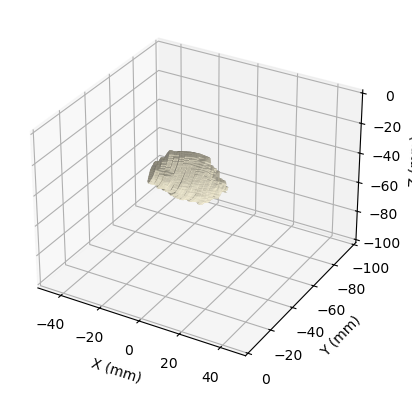

In [9]:
# Surface transform 3. 
# Combine rotation of 180 degrees around the x-axis, 
                    # 22.5 degrees around the y- axis and 
                    # 30 degrees around the z-axis 
# with a translation of 25 mm in the x-direction, 
                      # 15 mm in the y-direction and 
                      # -50 mm in the z-direction

# Trigonometric functions in numpy require angles given in radians

theta_x = np.pi
theta_y = -np.pi/8
theta_z = np.pi/6

# Rotation around the x-axis
Rot_X3 = np.array([[1, 0, 0, 0],
                  [0, np.cos(theta_x), -np.sin(theta_x), 0],
                  [0, np.sin(theta_x), np.cos(theta_x), 0],
                  [0, 0, 0, 1]])

# Rotation around the y-axis
Rot_Y3 = np.array([[np.cos(theta_y), 0, np.sin(theta_y), 0],
                  [0, 1 , 0, 0],
                  [-np.sin(theta_y), 0, np.cos(theta_y), 0],
                  [0, 0, 0, 1]])

Rot_Z3 = np.array([[np.cos(theta_z), -np.sin(theta_z), 0, 0],
                  [np.sin(theta_z), np.cos(theta_z) , 0, 0],
                  [0, 0 , 1, 0],
                  [0, 0, 0, 1]])


Translate_3 = np.transpose(np.array([[1, 0, 0, 25],
                        [0, 1, 0, 15],
                        [0, 0, 1, -50],
                        [0, 0, 0, 1]]))

transform_3 = Rot_X3 @ Rot_Y3 @ Rot_Z3 @ Translate_3

I3 = surface_transform(I0, transform_3)

x_I3 = I3[:, 0]
y_I3 = I3[:, 1]
z_I3 = I3[:, 2]

fig_I3 = plt.figure()
ax_I3 = fig_I3.add_subplot(111, projection='3d')

ax_I3.set_xlim(-50, 50)
ax_I3.set_ylim(-100, 0)
ax_I3.invert_yaxis()  
ax_I3.set_zlim(-100, 0)

ax_I3.set_xlabel("X (mm)")
ax_I3.set_ylabel("Y (mm)")
ax_I3.set_zlabel("Z (mm)")

# Plot transformed surface, I1:
ax_I3.plot_trisurf(x_I3, y_I3, z_I3, triangles = indices, color = "cornsilk")
plt.savefig("transformed_surface_3.png", format = "png")
plt.show()